
# Multi instrument joint analysis

Joint 3D analysis using 3D Fermi datasets, a H.E.S.S. reduced spectrum and CTA flux points.

**Constrain the spectral parameters of the gamma-ray
emission from the Crab nebula between 10 GeV and 100 TeV, using a 3D
Fermi dataset, a H.E.S.S. reduced spectrum and CTA flux points.**


This tutorial illustrates how to perform a joint modeling and fitting of
the Crab Nebula spectrum using different datasets. The spectral
parameters are optimized by combining a 3D analysis of Fermi-LAT data, a
ON/OFF spectral analysis of HESS data, and flux points from CTA.

## The setup


In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.maps import MapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import Models, create_crab_spectral_model

## Data and models files

The datasets serialization produce YAML files listing the datasets and
models. In the following cells we show an example containing only the
Fermi-LAT dataset and the Crab model.

We used as model a point source with a log-parabola spectrum. The
initial parameters were taken from the latest Fermi-LAT catalog
[4FGL](https://arxiv.org/abs/1902.10045)_, then we have re-optimized
the spectral parameters for our dataset in the 10 GeV - 2 TeV energy
range (fixing the source position).


## Reading different datasets

### Fermi-LAT 3FHL: map dataset for 3D analysis

For now we let’s use the datasets serialization only to read the 3D
`MapDataset` associated to Fermi-LAT 3FHL data and models.




In [2]:
datasets = Datasets.read(filename="$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_datasets.yaml")

models = Models.read("$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_models.yaml")
print(models)

Models

Component 0: SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.82e-02   +/- 3.0e-03 1 / (TeV s cm2)
    reference             (frozen):      0.000       TeV         
    alpha                         :      1.652   +/-    0.06             
    beta                          :      0.039   +/-    0.01             
    lon_0                 (frozen):     83.633       deg         
    lat_0                 (frozen):     22.020       deg         

Component 1: FoVBackgroundModel

  Name                      : Fermi-LAT-bkg
  Datasets names            : ['Fermi-LAT']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.300   +/-    0.08             
    tilt                  (frozen):      0.000         

/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/gammapy/utils/scripts.py:65: UserWarning: Checksum verification failed for /home/feijen/gammapy-datasets/1.2/fermi-3fhl-crab/Fermi-LAT-3FHL_datasets.yaml.
  warnings.warn(f"Checksum verification failed for {filename}.", UserWarning)


**Get the Crab model in order to share it with the other datasets:**

In [3]:
print(models['Crab Nebula'])

SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.82e-02   +/- 3.0e-03 1 / (TeV s cm2)
    reference             (frozen):      0.000       TeV         
    alpha                         :      1.652   +/-    0.06             
    beta                          :      0.039   +/-    0.01             
    lon_0                 (frozen):     83.633       deg         
    lat_0                 (frozen):     22.020       deg         




### HESS-DL3: 1D ON/OFF dataset for spectral fitting

The ON/OFF datasets can be read from PHA files. We read the PHA files from each observation, and compute a stacked dataset for simplicity.

In [4]:
datasets_hess = Datasets()

for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.read(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets_hess.append(dataset)

dataset_hess = datasets_hess.stack_reduce(name="HESS")

**Add this dataset to the existing dataset (it can be done in a typical Pythonic fashion, just like you would combine two lists!)**

In [5]:
datasets.append(dataset_hess)

### CTA-simulated: 1D ON/OFF dataset for spectral fitting

We read the PHA files from each observation, and compute a stacked
dataset for simplicity.

In [6]:
flux_points_cta = FluxPoints.read(f"../gammapy-ORP/data/cta_simulation_flux_points.fits")

**Utilise the above to create a `FluxPointsDataset` object, with the name 'CTA'.**

In [7]:
dataset_cta = FluxPointsDataset(data=flux_points_cta, name='CTA')

In [8]:
datasets.append(dataset_cta)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : CTA
  Instrument : 
  Models     : 




## Datasets serialization

The `datasets` object contains each dataset previously defined. It can
be saved on disk as datasets.yaml, models.yaml, and several data files
specific to each dataset.

```
filename = "spectra/crab_10GeV_100TeV_datasets.yaml"
datasets.write(filename, overwrite=True)

datasets = Datasets.read(filename)
```


**Apply the models to the dataset. Hint: we did this in the previous tutorial!**

In [9]:
datasets.models = models

## Joint analysis

We run the fit on the `Datasets` object that include a dataset for
each instrument.

In [10]:
fit_joint = Fit()

**Run the fit on the dataset**

In [11]:
results_joint = fit_joint.run(datasets)

HDU 'MASK_FIT' not found


Let’s display only the parameters of the Crab spectral model

In [12]:
crab_spec = datasets[0].models["Crab Nebula"].spectral_model
print(crab_spec)

LogParabolaSpectralModel

type    name     value         unit      ... frozen is_norm link prior
---- --------- ---------- -------------- ... ------ ------- ---- -----
     amplitude 8.2460e-03 TeV-1 s-1 cm-2 ...  False    True           
     reference 5.0548e-05            TeV ...   True   False           
         alpha 1.4444e+00                ...  False   False           
          beta 5.1557e-02                ...  False   False           


We can compute flux points for Fermi-LAT, HESS and CTA datasets.

In [13]:
# compute Fermi-LAT flux points
energy_edges = MapAxis.from_energy_bounds("10 GeV", "2 TeV", nbin=5).edges
flux_points_fermi = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="Crab Nebula",
).run([datasets["Fermi-LAT"]])

Compute the Flux points for the HESS instrument. 

**Here we want a logarithmic interpretation with 6 bins from 1-15TeV**

In [14]:
energy_edges = MapAxis.from_bounds(1, 15, nbin=6, interp="log", unit="TeV").edges
flux_points_hess = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="Crab Nebula",
    selection_optional=["ul"]
).run([datasets["HESS"]])

Now, let’s plot the Crab spectrum fitted and the flux points of each
instrument.

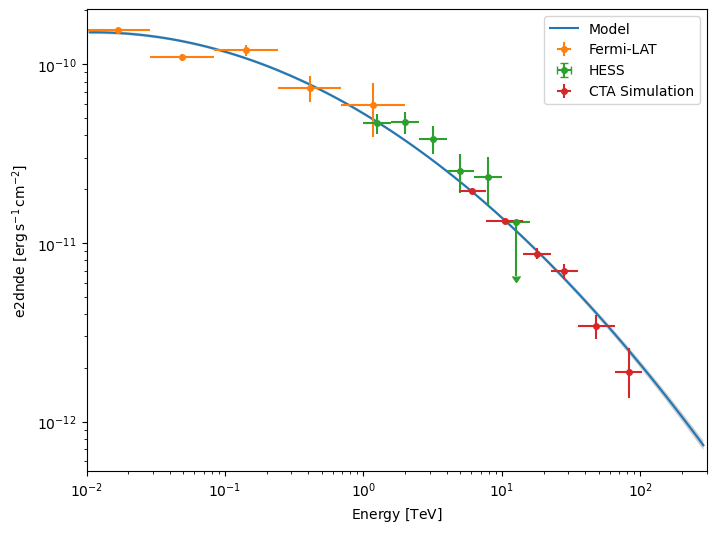

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

energy_bounds = [0.01, 300] * u.TeV
sed_type = "e2dnde"

crab_spec.plot(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
crab_spec.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)

flux_points_fermi.plot(ax=ax, sed_type=sed_type, label="Fermi-LAT")
flux_points_hess.plot(ax=ax, sed_type=sed_type, label="HESS")
flux_points_cta.plot(ax=ax, sed_type=sed_type, label="CTA Simulation")

ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

## Horray! We have performed a joint analysis with 3 different instruments